## Initial data transformation and processing

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_array = sio.loadmat('data/XDATA.mat')['DATASET']

Original dataset has all variables as imaginary numbers, for most of them the imaginary part is zero. But for FFT variables imaginary part is non-zero.

We'll split variables with imaginary part in real and imaginary as separate variables. Then, all variables will be represented as floats.

In [30]:
# Get only real part
data_float = data_array.copy().real.astype(float)
# Get imaginary part
imaginary_L_FFT = data_array.imag[:, 597:797]
imaginary_R_FFT = data_array.imag[:, 797:997]
# Array with all variables as float (includding imaginary part as a separate variable)
all_float_array = np.hstack((data_float[:, :997], imaginary_L_FFT, imaginary_R_FFT, data_float[:, 997:]))

In [31]:
# Imaginary components are now separated
print 'original dataset shape:', data_array.shape
print 'all floats dataset shape:', all_float_array.shape

original dataset shape: (65600, 1039)
all floats dataset shape: (65600, 1439)


Now we will include feature names:

In [33]:
column_names = []
for i in range(200):
    column_names.append('L_HRIR_{:d}'.format(i))
for i in range(200):
    column_names.append('R_HRIR_{:d}'.format(i))
for i in range(98):
    column_names.append('L_HRTF_{:d}'.format(i))
for i in range(98):
    column_names.append('R_HRTF_{:d}'.format(i))
for i in range(200):
    column_names.append('L_FFT_real_{:d}'.format(i))
for i in range(200):
    column_names.append('R_HRIR_real_{:d}'.format(i))
for i in range(200):
    column_names.append('L_FFT_imag_{:d}'.format(i))
for i in range(200):
    column_names.append('R_HRIR_imag_{:d}'.format(i))
# Interaction Parameters
# Time-arrival Difference
column_names.append('ITD')
# Intensity Difference
column_names.append('IID')
# Spectral Difference
column_names.append('DS')
# Head Parameters
column_names.append('head_width')
column_names.append('head_height')
column_names.append('head_depth')
column_names.append('pinna_offset_down')
column_names.append('pinna_offset_back')
column_names.append('neck_width')
column_names.append('neck_height')
column_names.append('neck_depth')
column_names.append('torso_top_width')
column_names.append('torso_top_heigth')
column_names.append('torso_top_depth')
column_names.append('shoulder_width')
column_names.append('head_offset_forward')
column_names.append('height')
column_names.append('seated_height')
column_names.append('head_circumference ')
column_names.append('shoulder_circumference')

# Ear Parameters
column_names.append('L_cavum_concha_heigth')
column_names.append('L_cymba_concha_heigth')
column_names.append('L_cavum_concha_width')
column_names.append('L_fossa_height')
column_names.append('L_pinna_height')
column_names.append('L_pinna_width')
column_names.append('L_intertragal_incisure_width')
column_names.append('L_cavum_concha_depth')
column_names.append('R_cavum_concha_heigth')
column_names.append('R_cymba_concha_heigth')
column_names.append('R_cavum_concha_width')
column_names.append('R_fossa_height')
column_names.append('R_pinna_height')
column_names.append('R_pinna_width')
column_names.append('R_intertragaR_incisure_width')
column_names.append('R_cavum_concha_depth')

# Pinnae Rotation Parameters
column_names.append('L_pinna_rotation_angle')
column_names.append('L_pinna_flare_angle')
column_names.append('R_pinna_rotation_angle')
column_names.append('R_pinna_flare_angle')

# Target
column_names.append('azimuth')
column_names.append('elevation')

# Subject Id
column_names.append('subject_id')

In [34]:
df = pd.DataFrame(all_float_array, columns=column_names)

In [73]:
# col_ix Dictionary can be used to get the index of any feature
col_ix = {}
for i, col in enumerate(df.columns):
    col_ix[col] = i

Full dataset contains data from two original datasets.

For the moment we will work with the first dataset only.

In [60]:
ds_1 = df.iloc[:56249]

In [107]:
# Unique Subjects = 95
ds_1.subject_id = ds_1.subject_id.astype(int)
ds_1.subject_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

## Inter-subject variation for same azimuth and elevation angles

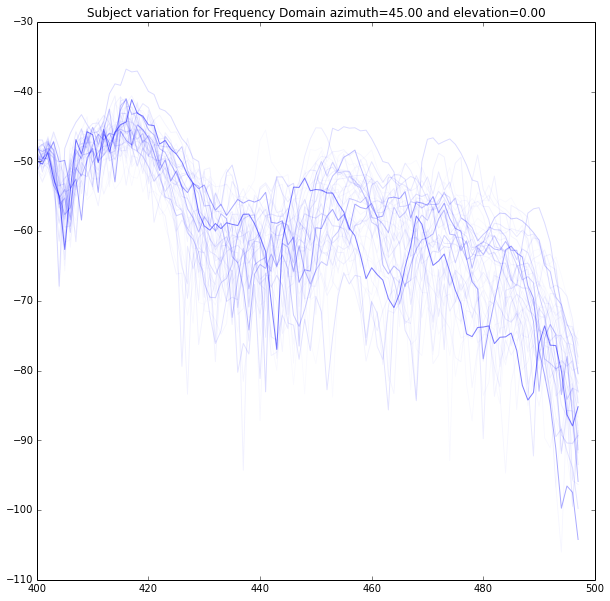

In [194]:
plt.figure(figsize=(10, 10))
#azimuth = np.random.randint(-180, 175)
#elevation = np.random.randint(-50, 90)
azimuth, elevation = 45.0, 0.0 
location = ds_1[(ds_1.azimuth == azimuth) & (ds_1.elevation == elevation)]
location2 = ds_1[(ds_1.azimuth == 0.0) & (ds_1.elevation == 0.0)]
location3 = ds_1[(ds_1.azimuth == -45.0) & (ds_1.elevation == elevation)]
range_ = range(400, 498)
l_hrtf = location.iloc[:,range_]
r_hrtf = location.iloc[:, range_]
j = 1
for i in range(1, 45):
    first = l_hrtf[location.subject_id == i].iloc[0]
    plt.plot(range_, first, c='b', alpha=1.0/(j+1))
    #plt.plot(range(98), r_hrir.iloc[i], c='r', alpha=1.0/(j+1))
    j += 1
plt.legend(loc='upper right')
plt.title('Subject variation for Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

In [152]:
np.array(l_hrtf[location.subject_id == 5].iloc[0])

array([-59.32318282, -58.78298267])

In [161]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_absolute_error
from math import ceil

## Baseline Regression Tree model

In [162]:
# Fit regression model
# Only use this columns for the moment
cols_range = range(0, 1399) + range(-3, 0, 1)
ds_1 = ds_1.ix[:, cols_range]
n = 45
train_size = ceil(n*0.8)
shuffled_ix = np.random.choice(range(n), n, replace=False)
train_ix, test_ix = shuffled_ix[:train_size], shuffled_ix[train_size:]

train = ds_1[ds_1.subject_id.isin(train_ix)]
test = ds_1[ds_1.subject_id.isin(test_ix)]

/Users/mati/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [68]:
X_train, y_train = train.ix[:, :-3], train.ix[:, -3:-2]
X_test, y_test = test.ix[:, :-3], test.ix[:, -3:-2]

In [130]:
print 'subject in train set:', train.subject_id.unique()
print 'subject in test set:', test.subject_id.unique()

subject in train set: [ 1  2  3  4  5  6  7  8  9 10 13 15 16 18 19 21 22 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 43]
subject in test set: [11 12 14 17 20 23 24 42 44]


Frequency series for subjects in Training and Test Sets

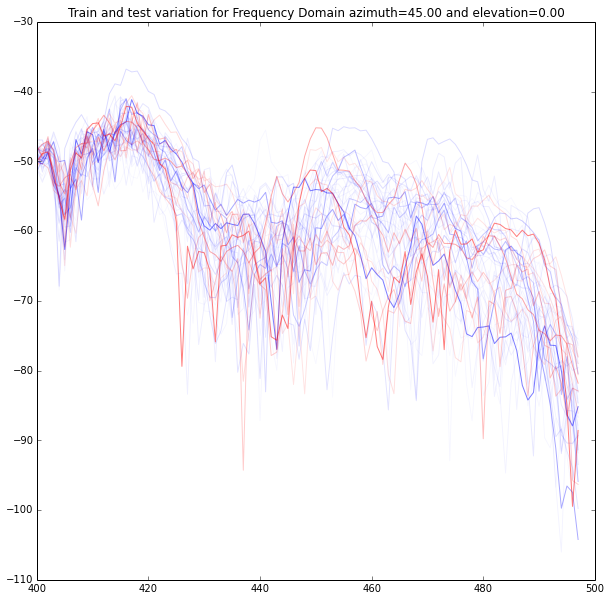

In [160]:
plt.figure(figsize=(10, 10))
#azimuth = np.random.randint(-180, 175)
#elevation = np.random.randint(-50, 90)
azimuth, elevation = 45.0, 0.0
range_ = range(400, 498)
train_location = train[(ds_1.azimuth == azimuth) & (ds_1.elevation == elevation)]
test_location = test[(ds_1.azimuth == azimuth) & (ds_1.elevation == elevation)]
l_hrtf = train_location.iloc[:, range_]
l_hrtf_test = test_location.iloc[:, range_]
j = 1
for i in train.subject_id.unique():
    subj_train = l_hrtf[train.subject_id == i].iloc[0]
    plt.plot(range_, subj_train, c='b', alpha=1.0/(j+1))
    j += 1
j = 1
for i in test.subject_id.unique():
    subj_test = l_hrtf_test[test.subject_id == i].iloc[0]
    plt.plot(range_, subj_test, c='r', alpha=1.0/(j+1))
    j += 1
    
plt.legend(loc='upper right')
plt.title('Train and test variation for Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

In [163]:
print X_train.shape
print X_test.shape

(43749, 1399)
(12500, 1399)


In [164]:
# Regression Tree Baseline Model
regr = DecisionTreeRegressor(max_depth=4)
regr.fit(X_train, y_train)

with open('tree' + str(4) + '.dot', 'w') as dotfile:
    export_graphviz(
        regr,
        dotfile,
        feature_names=X_train.columns)

# Predict
y_pred = regr.predict(X_test)
loss = mean_absolute_error(y_test, y_pred)

print loss

5.33333333333


In [193]:
print (data_array[:, 638] == df.azimuth).sum()
print (data_array[:, 639] == df.elevation).sum()

65600
65600


In [180]:
df.iloc[:, [638, -3]].corr()

,L_FFT_real_42,azimuth
L_FFT_real_42,1,1
azimuth,1,1


Model is "too good to be true", leackage identified fro original dataset.